In [26]:
%load_ext autoreload
%autoreload 2
from helper import create_tsp_graph,plot_tsp_graph,bitstring_to_path,cost
from classical import solve_tsp_classical
from alternating_operator import get_expectation,analyse_result,create_qaoa_circ
from scipy.optimize import minimize
from qiskit.tools.visualization import plot_histogram
from qiskit import transpile,Aer
from qaoa import get_expectation_qaoa,create_classical_qaoa_circ
import pickle
from numpy.random import rand

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
reps = 2
ncities = 4

In [37]:
G = create_tsp_graph(ncities)

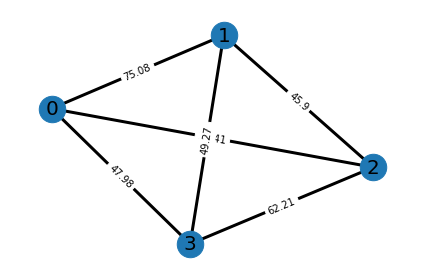

In [38]:
plot_tsp_graph(G)

In [45]:
expectation = get_expectation(G,reps,shots=1024,log_intermediate_counts=True)

res = minimize(expectation,
               [1. if i<reps*2 else np.random.rand()*2 for i in range(reps*4)],
                      method='COBYLA',
                      options = {'tol' : 1e-6,'disp' : True,'maxiter':150})

Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.


Current expected cost: 209.29
Current expected cost: 209.29
Current expected cost: 209.29
Current expected cost: 209.29
Current expected cost: 209.29
Current expected cost: 210.04
Current expected cost: 209.84
Current expected cost: 209.29
Current expected cost: 209.45
Current expected cost: 211.96
Current expected cost: 212.76
Current expected cost: 210.4
Current expected cost: 209.29
Current expected cost: 207.06
Current expected cost: 226.33
Current expected cost: 207.06
Current expected cost: 222.33
Current expected cost: 207.06
Current expected cost: 203.33
Current expected cost: 225.96
Current expected cost: 203.33
Current expected cost: 225.96
Current expected cost: 203.33
Current expected cost: 225.96
Current expected cost: 217.54
Current expected cost: 229.1
Current expected cost: 220.99
Current expected cost: 203.33
Current expected cost: 218.49
Current expected cost: 212.93
Current expected cost: 224.28
Current expected cost: 203.33
Current expected cost: 211.34
Current expe

In [41]:
with open(".\data\G", "wb") as fp:   #Pickling
    pickle.dump(G,fp)

In [46]:
res

     fun: 196.37470160510347
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 140
  status: 1
 success: True
       x: array([0.99807674, 0.99735368, 1.        , 0.99999965, 0.99863882,
       1.74103996, 1.24593838, 1.96463201])

Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.


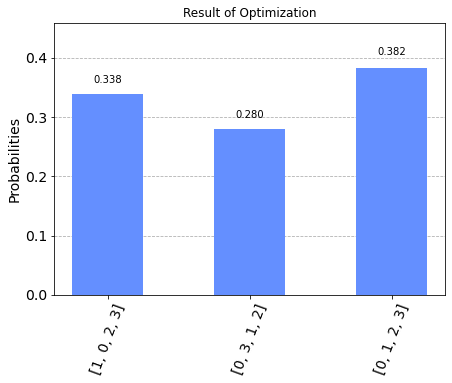

In [43]:
fig,counts = analyse_result(G,res.x,reps=reps,transform_labels_to_path=True,filter_unique_path=True,save_plot=True)
fig

In [253]:
for key, val in counts.items():
    if val>1:
        path = bitstring_to_path(key)
        print(path,':', val , f"   cost = {round(cost(G,path),2)}")

[3, 0, 1, 2] : 1024    cost = 84.62


In [39]:
solve_tsp_classical(G)

([0, 3, 1, 2], 171.56367752716903)

In [276]:
expectation_qaoa = get_expectation_qaoa(G,reps,shots=1024,penalty=1.,log_intermediate_counts=True)

res_qaoa = minimize(expectation_qaoa,
               [1 for _ in range(reps*2)] ,
                      method='COBYLA',
                      options = {'tol' : 1e-4,'disp' : True})

Current expected cost: 279.01
Current expected cost: 279.01
Current expected cost: 279.01
Current expected cost: 204.5
Current expected cost: 279.01
Current expected cost: 277.66
Current expected cost: 204.5
Current expected cost: 277.66
Current expected cost: 252.16
Current expected cost: 221.31
Current expected cost: 208.79
Current expected cost: 204.5
Current expected cost: 208.79
Current expected cost: 205.59
Current expected cost: 204.79
Current expected cost: 204.57
Current expected cost: 204.5
Current expected cost: 204.57
Current expected cost: 204.57
Current expected cost: 204.5
Current expected cost: 204.5
Current expected cost: 204.5
Current expected cost: 204.5
Current expected cost: 204.5


In [176]:
res_qaoa

     fun: 500.09391155402056
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 13
  status: 1
 success: True
       x: array([1., 1.])

Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.


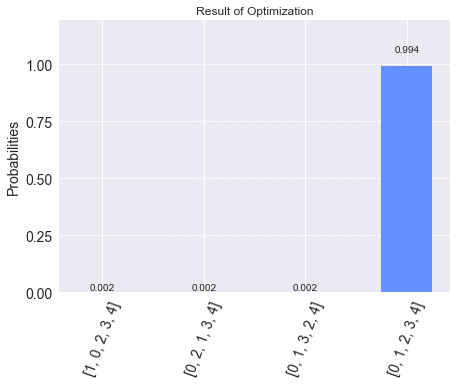

In [218]:
fig,counts = analyse_result(G,np.hstack([np.array([1.,1.]),res_qaoa.x]),reps=reps,transform_labels_to_path=True,filter_unique_path=True)
fig

## If 0,1,2,3,4 is "good" -> the algorithm almost always converges to that value 

In [223]:
def compute_circuit_sizes(ncities_max=6,reps=1):
    sizes_alternating_operator = []
    sizes_qaoa = []
    simulator = Aer.get_backend('aer_simulator')
    x = []
    
    for ncities in range(2,ncities_max+1,1):
        G = create_tsp_graph(ncities)
        x.append(ncities)
        
        alt_op = create_qaoa_circ(G,reps=reps)
        alt_op = transpile(alt_op, simulator,optimization_level = 3)
        sizes_alternating_operator.append(alt_op.depth())
        
        qaoa = create_classical_qaoa_circ(G,reps=reps)
        qaoa = transpile(qaoa, simulator,optimization_level = 1)
        sizes_qaoa.append(qaoa.depth())
    
    
    return (x,sizes_alternating_operator,sizes_qaoa)
        

In [225]:
compute_circuit_sizes(5,2)

([2, 3, 4, 5], [136, 771, 1656, 2738], [12, 37, 85, 211])

In [242]:
a = {'1000000101000010': 180.866, '1000010000100001': 234.667, '0010100001000001': 238.15}
b ={'1000000101000010': 210, '1000010000100001': 443, '0010100001000001': 371}

In [246]:
'0010100001000001' in b

True